<h1 align= 'center'><font size ="10"> Deep Convolutional GAN (DCGAN) <font><h1>

#### we will train a DCGAN model to generate low-resolution (64 x 64 pixels) images of stop-sign. Note that if you want to create higher resolution images, it still work. But remember, the larger the image, the more computer power you'll need.

## Step 1: Import libraries

In [1]:
# Tensorflow / Keras
from tensorflow import keras  # Importing the TensorFlow library for building Neural Networks
from keras.models import Sequential  # Importing the Sequential model for assembling a Neural Network model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout  # Importing different layers to add to the Neural Network model
from tensorflow.keras.utils import plot_model  # Importing plot_model for visualizing the model architecture
from tensorflow.keras.optimizers import Adam  # Importing the Adam optimizer for model optimization

# Data manipulation
import numpy as np  # Importing numpy for numerical data manipulation
print('numpy: %s' % np.__version__)  # Printing the version of numpy being used
import sklearn  # Importing scikit-learn for various machine learning tools
print('sklearn: %s' % sklearn.__version__)  # Printing the version of scikit-learn being used
from sklearn.preprocessing import MinMaxScaler  # Importing MinMaxScaler for scaling inputs used in the generator and discriminator

# Visualization
import cv2  # Importing OpenCV for image processing tasks
print('OpenCV: %s' % cv2.__version__)  # Printing the version of OpenCV being used
import matplotlib  # Importing matplotlib for data visualization
import matplotlib.pyplot as plt  # Importing pyplot module from matplotlib for plotting graphs
print('matplotlib: %s' % matplotlib.__version__)  # Printing the version of matplotlib being used
import graphviz  # Importing graphviz for showing model diagrams
print('graphviz: %s' % graphviz.__version__)  # Printing the version of graphviz being used

# Other utilities
import sys  # Importing sys module for system-specific parameters and functions
import os  # Importing os module for interacting with the operating system

# Assign main directory to a variable
main_dir = os.path.dirname(sys.path[0])  # Assigning the main directory path to a variable
# print(main_dir)  # Printing the main directory path (if needed)

numpy: 1.25.2
sklearn: 1.2.2
OpenCV: 4.8.0
matplotlib: 3.7.1
graphviz: 0.20.3


## Step 2: Prepare the data. For that download the data from Caltech 101 image dataset ([source](https://data.caltech.edu/records/mzrjq-6wc02))

In [2]:
# Specify the location of images after you have downloaded them
ImgLocation = main_dir + "/data/"  # Concatenating the main directory path with the location of the image data

# List image categories we are interested in (We will only use "faces" this time)
CATEGORIES = (["faces_small"])  # Defining the categories of images to be used

# Create a list to store image paths
ImagePaths = []  # Initializing an empty list to store the paths of the images
for category in CATEGORIES:  # Looping through each category
    for image in list(os.listdir(ImgLocation + category)):  # Iterating over each image in the category
        ImagePaths = ImagePaths + [ImgLocation + category + "/" + image]  # Appending the image path to the list

# Load images and resize to 64 x 64
data_lowres = []  # Initializing an empty list to store the resized images
for img in ImagePaths:  # Looping through each image path
    image = cv2.imread(img)  # Reading the image using OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converting the color format from BGR to RGB
    image_lowres = cv2.resize(image, (64, 64))  # Resizing the image to 64x64 pixels
    data_lowres.append(image_lowres)  # Appending the resized image to the list

# Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
data_lowres = np.array(data_lowres, dtype="float") / 255.0  # Converting the list of images to a numpy array and normalizing pixel values

# Show data shape
print("Shape of data_lowres: ", data_lowres.shape)  # Printing the shape of the array containing the image data

Shape of data_lowres:  (75, 64, 64, 3)


### Displaying few real images (64 x 64 pixels)

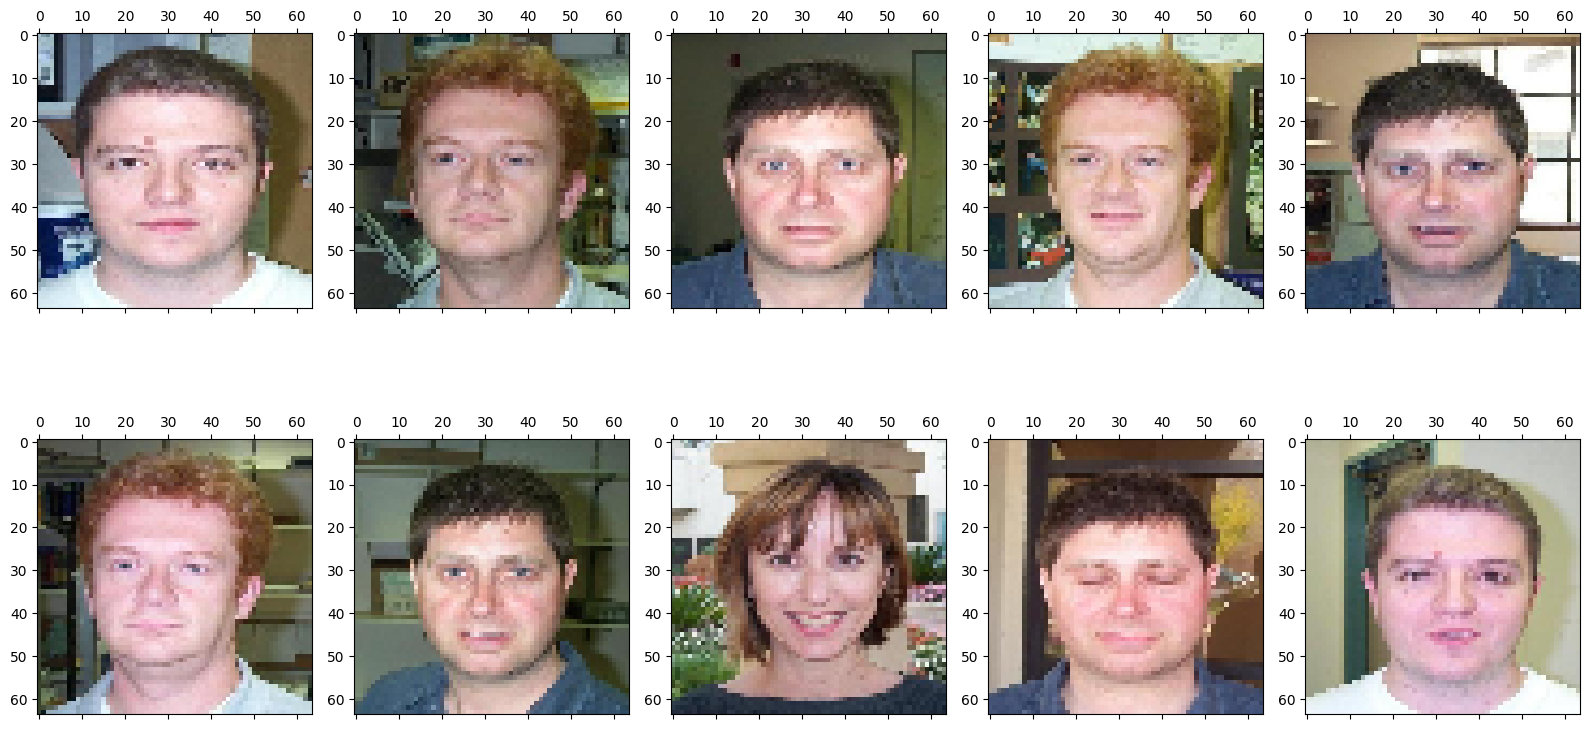

In [3]:
# Display 10 real images
# Create a figure and axes for plotting
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')

# Initialize a counter for indexing the images
n = 0

# Loop through each subplot
for i in range(0, 2):  # Iterate over rows
    for j in range(0, 5):  # Iterate over columns
        # Plot the image corresponding to the current index
        axs[i, j].matshow(data_lowres[n])  # Display the image using matshow
        n = n + 1  # Increment the counter to move to the next image

# Show the plot
plt.show()

Let's adjust our image data's range. Right now, it range of [0,1]. We'll change it to [-1,1]. Why? Well, this makes it easier to use a tanh activation function in our Generator output. This function often gives better results.

In [4]:
# Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))  # Initializing MinMaxScaler with a feature range of (-1, 1)

# Select images that we want to use for model training
data = data_lowres.copy()  # Creating a copy of the original image data
print("Original shape of the data: ", data.shape)  # Printing the original shape of the data

# Reshape array
data = data.reshape(-1, 1)  # Reshaping the array to a single column
print("Reshaped data: ", data.shape)  # Printing the shape of the reshaped data

# Fit the scaler
scaler.fit(data)  # Fitting the scaler to the data

# Scale the array
data = scaler.transform(data)  # Scaling the data using the fitted scaler

# Reshape back to the original shape
data = data.reshape(data_lowres.shape[0], 64, 64, 3)  # Reshaping the scaled data back to the original shape
print("Shape of the scaled array: ", data.shape)  # Printing the shape of the scaled array

Original shape of the data:  (75, 64, 64, 3)
Reshaped data:  (921600, 1)
Shape of the scaled array:  (75, 64, 64, 3)


### Step 3: Setup DCGAN
#### Define Generator model

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (  (None, 8192)              827392    
 Dense)                                                          
                                                                 
 Generator-Hidden-Layer-Res  (None, 8, 8, 128)         0         
 hape-1 (Reshape)                                                
                                                                 
 Generator-Hidden-Layer-2 (  (None, 16, 16, 128)       262272    
 Conv2DTranspose)                                                
                                                                 
 Generator-Hidden-Layer-Act  (None, 16, 16, 128)       0         
 ivation-2 (ReLU)                                                
                                                                 
 Generator-Hidden-Layer-3 (  (None, 32, 32, 256)       52

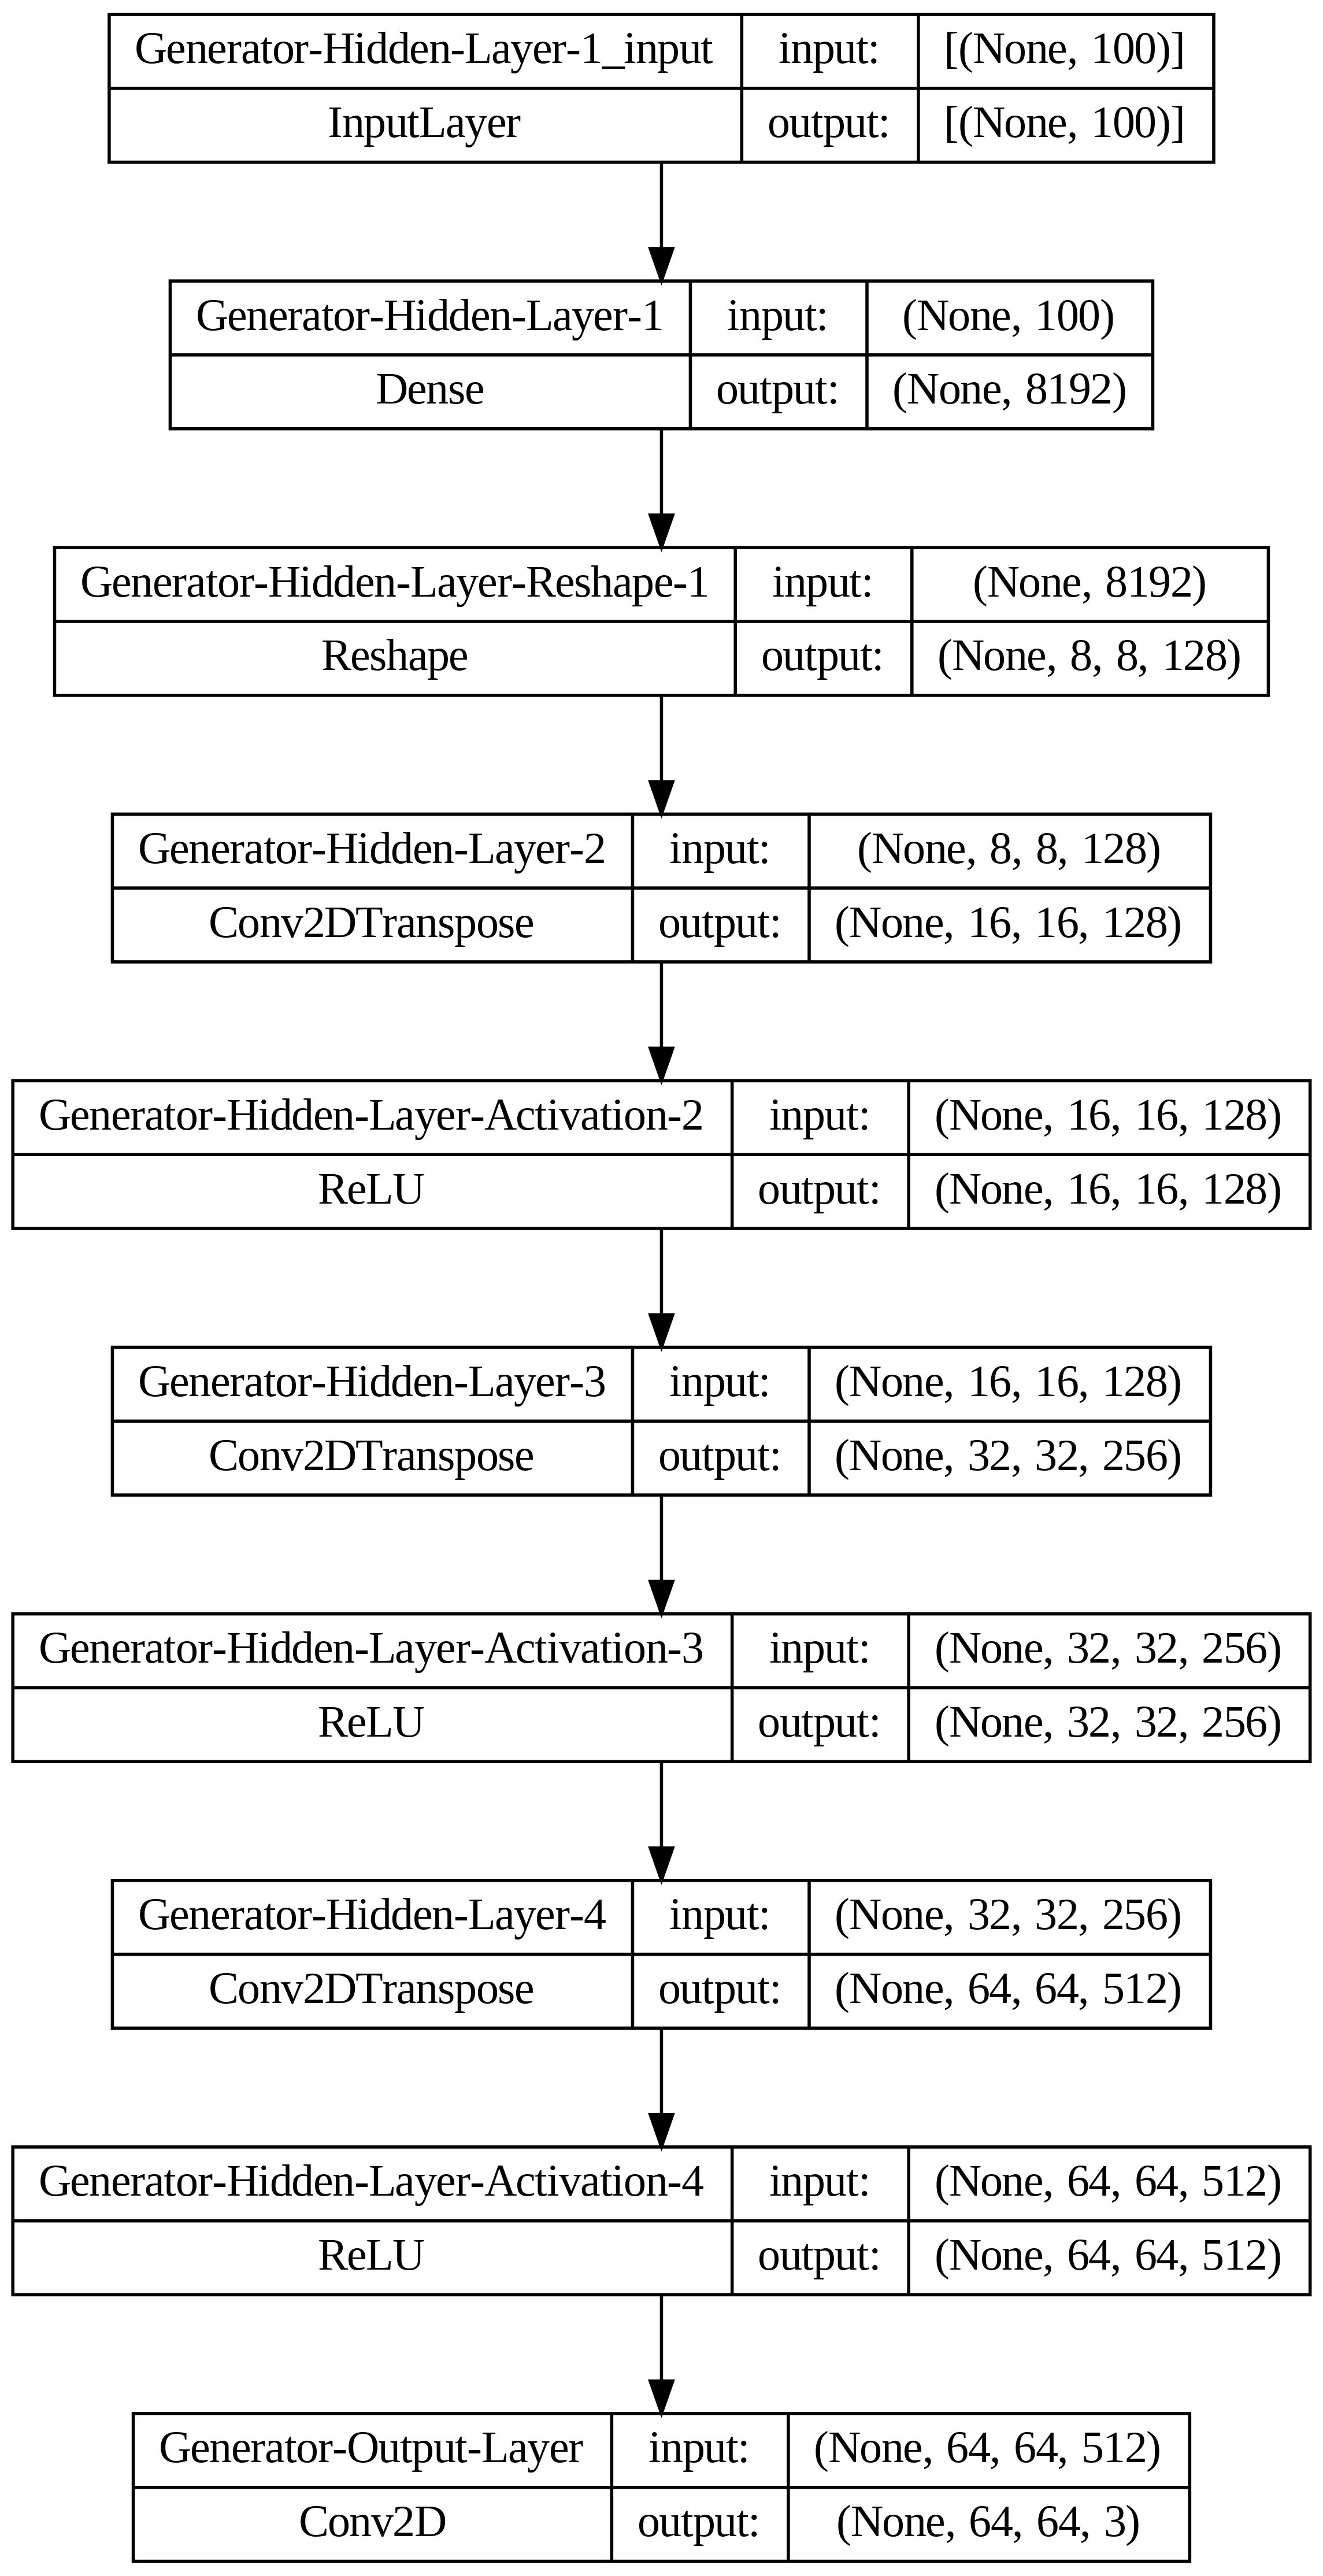

In [5]:
def generator(latent_dim):
    model = Sequential(name="Generator")  # Creating a Sequential model named "Generator"

    # Hidden Layer 1: Start with 8 x 8 image
    n_nodes = 8 * 8 * 128  # Calculating the number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_dim=latent_dim, name='Generator-Hidden-Layer-1'))  # Adding a Dense layer with the specified number of nodes and input dimension
    model.add(Reshape((8, 8, 128), name='Generator-Hidden-Layer-Reshape-1'))  # Reshaping the output of the Dense layer to form a 3D image shape

    # Hidden Layer 2: Upsample to 16 x 16
    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2'))  # Adding a Conv2DTranspose layer to upsample the image
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-2'))  # Adding a ReLU activation function to the output of the Conv2DTranspose layer

    # Hidden Layer 3: Upsample to 32 x 32
    model.add(Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-3'))  # Adding another Conv2DTranspose layer for further upsampling
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-3'))  # Adding a ReLU activation function

    # Hidden Layer 4: Upsample to 64 x 64
    model.add(Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-4'))  # Adding another Conv2DTranspose layer for final upsampling
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-4'))  # Adding a ReLU activation function

    # Output Layer (Note, we use 3 filters because we have 3 channels for a color image. Grayscale would have only 1 channel)
    model.add(Conv2D(filters=3, kernel_size=(5,5), activation='tanh', padding='same', name='Generator-Output-Layer'))  # Adding the output Conv2D layer with tanh activation function
    return model  # Returning the constructed generator model

# Instantiate
latent_dim = 100  # Setting the dimensionality of the latent space
gen_model = generator(latent_dim)  # Creating an instance of the generator model with the specified latent dimension

# Show model summary and plot model diagram
gen_model.summary()  # Displaying the summary of the generator model
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=400)  # Plotting the architecture of the generator model

#### Define Discriminator model

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer  (None, 32, 32, 64)        3136      
 -1 (Conv2D)                                                     
                                                                 
 Discriminator-Hidden-Layer  (None, 32, 32, 64)        0         
 -Activation-1 (LeakyReLU)                                       
                                                                 
 Discriminator-Hidden-Layer  (None, 16, 16, 128)       131200    
 -2 (Conv2D)                                                     
                                                                 
 Discriminator-Hidden-Layer  (None, 16, 16, 128)       0         
 -Activation-2 (LeakyReLU)                                       
                                                                 
 Discriminator-Hidden-Layer  (None, 8, 8, 128)       

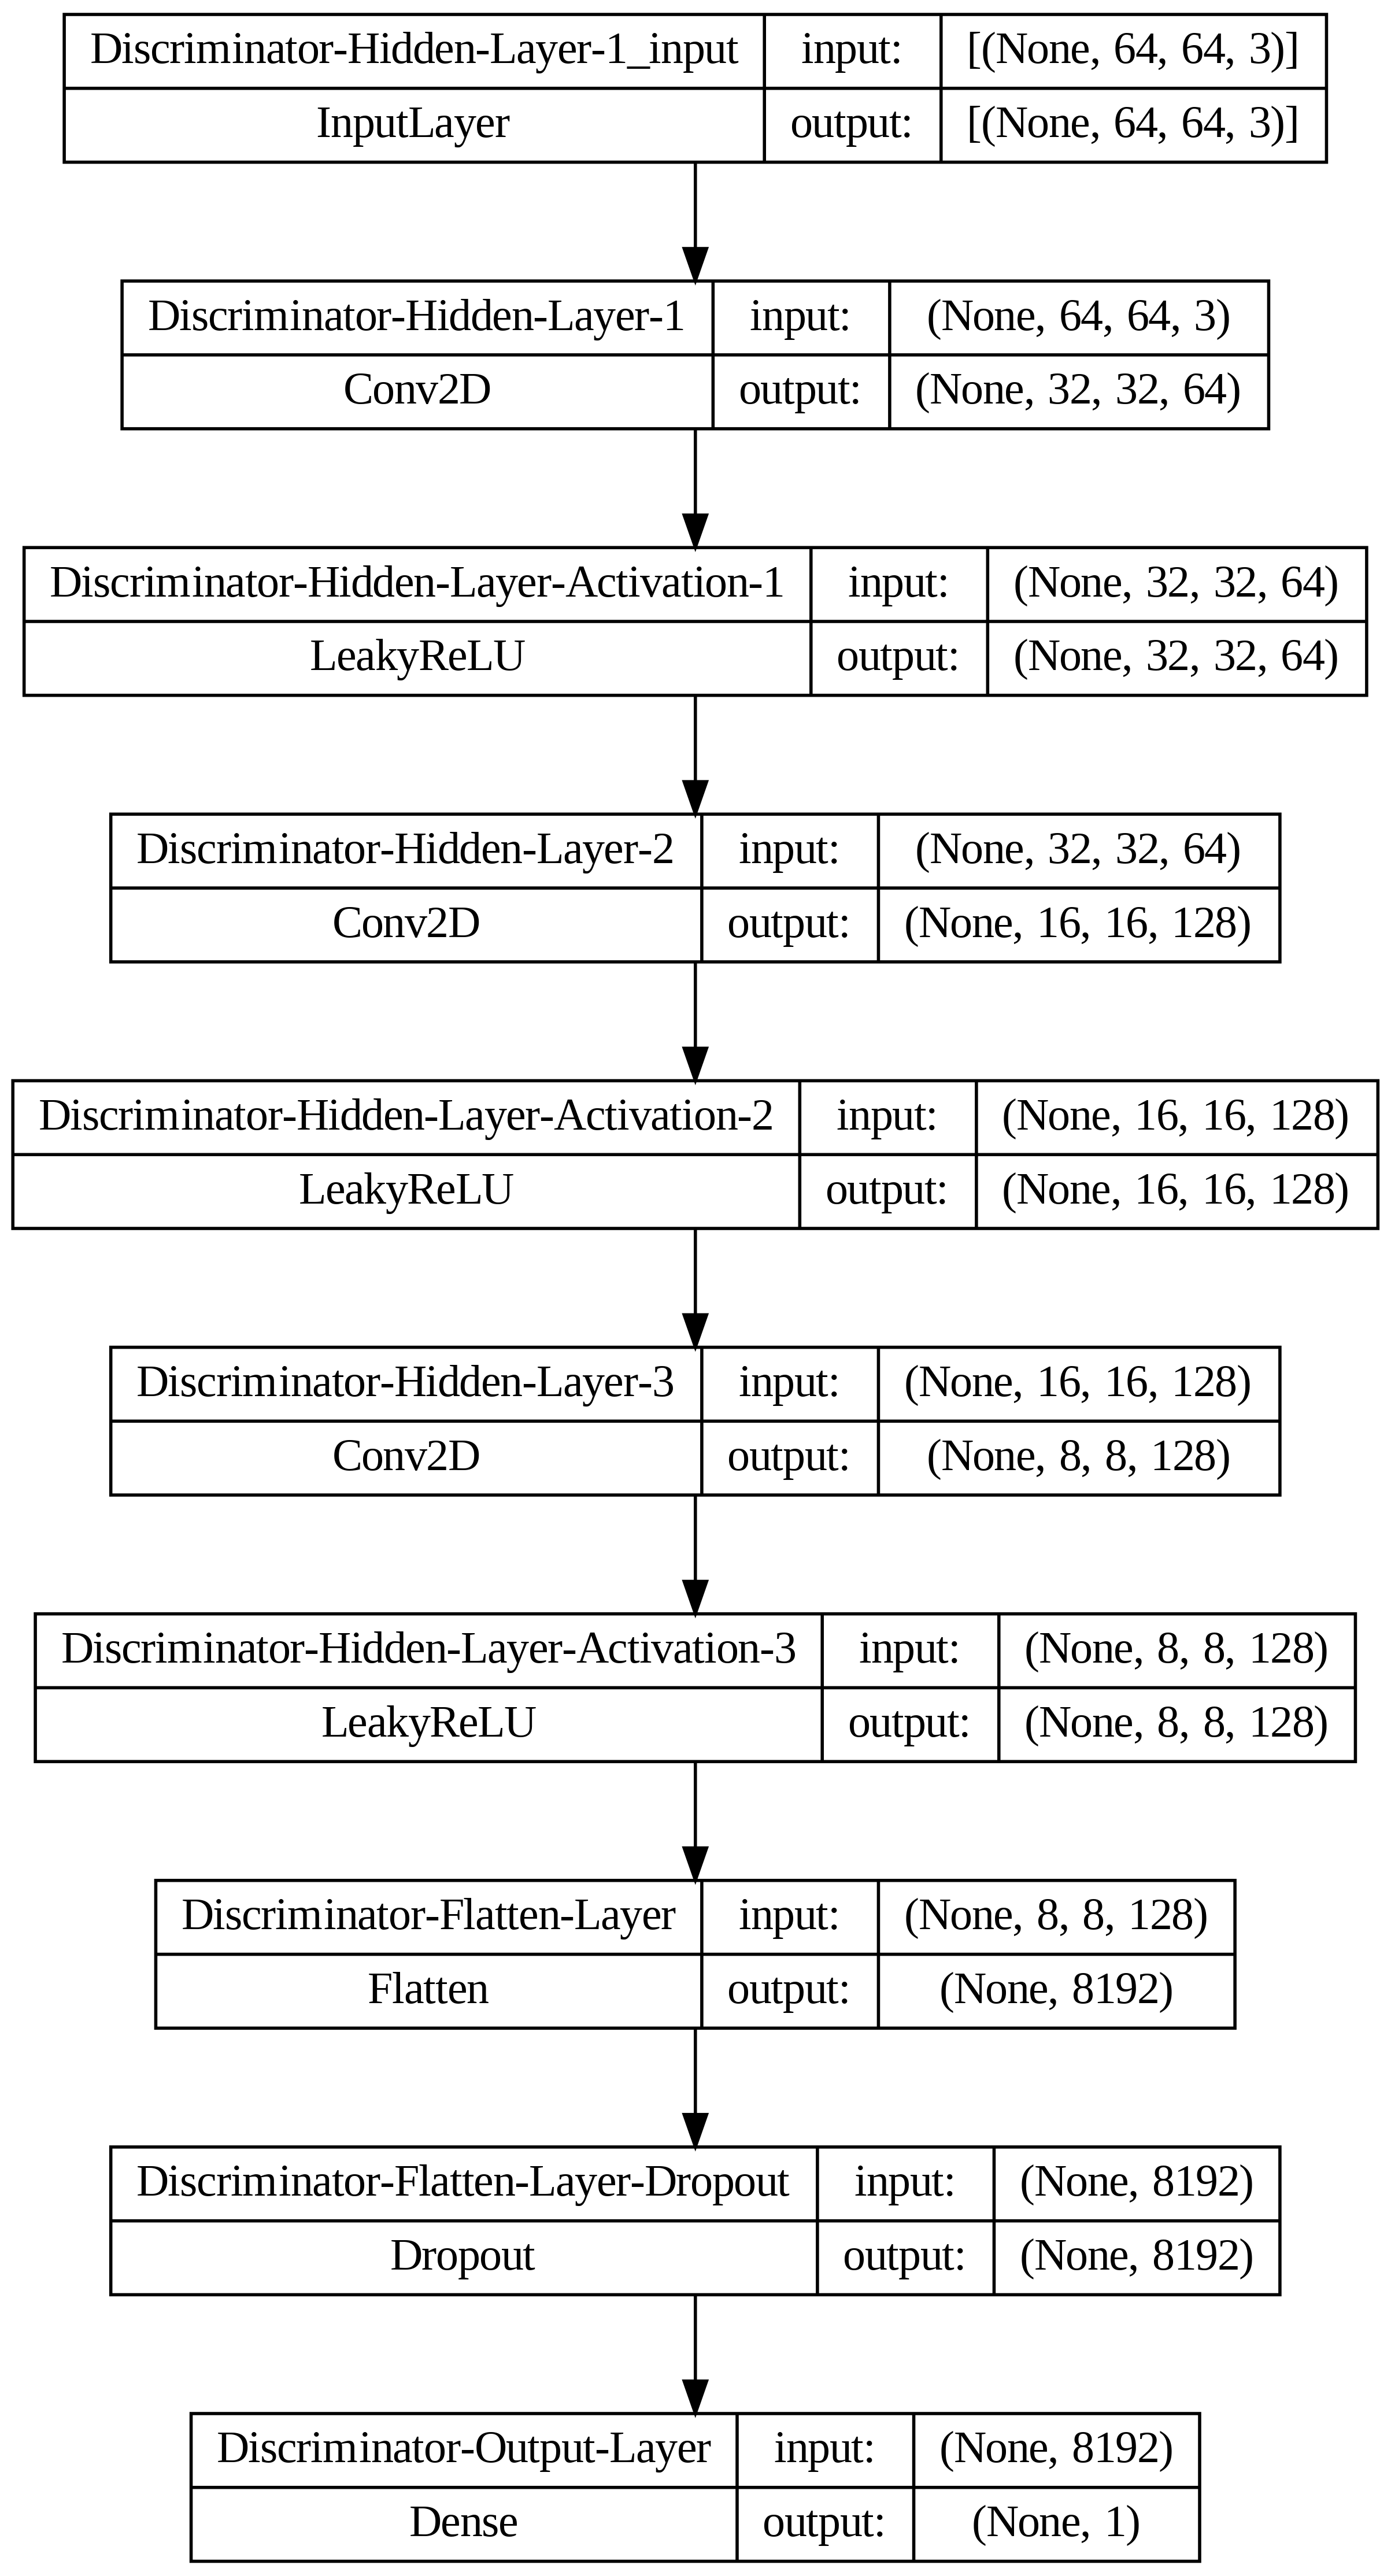

In [6]:
def discriminator(in_shape=(64, 64, 3)):
    model = Sequential(name="Discriminator")  # Creating a Sequential model named "Discriminator"

    # Hidden Layer 1
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-1'))  # Adding a Conv2D layer with 64 filters
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))  # Adding a LeakyReLU activation function with alpha set to 0.2

    # Hidden Layer 2
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-2'))  # Adding another Conv2D layer with 128 filters
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))  # Adding a LeakyReLU activation function

    # Hidden Layer 3
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-3'))  # Adding another Conv2D layer with 128 filters
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))  # Adding a LeakyReLU activation function

    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer'))  # Flattening the output of the convolutional layers
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout'))  # Adding a Dropout layer to randomly drop connections
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer'))  # Adding the output Dense layer with sigmoid activation function

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])  # Compiling the model with binary crossentropy loss and Adam optimizer
    return model  # Returning the constructed discriminator model

# Instantiate
dis_model = discriminator()  # Creating an instance of the discriminator model

# Show model summary and plot model diagram
dis_model.summary()  # Displaying the summary of the discriminator model
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400)  # Plotting the architecture of the discriminator model

### If you notice the discriminator model does opposite of generator model.
### we will combine the two models to create DCGAN

Model: "DCGAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 64, 64, 3)         3750275   
                                                                 
 Discriminator (Sequential)  (None, 1)                 404801    
                                                                 
Total params: 4155076 (15.85 MB)
Trainable params: 3750275 (14.31 MB)
Non-trainable params: 404801 (1.54 MB)
_________________________________________________________________


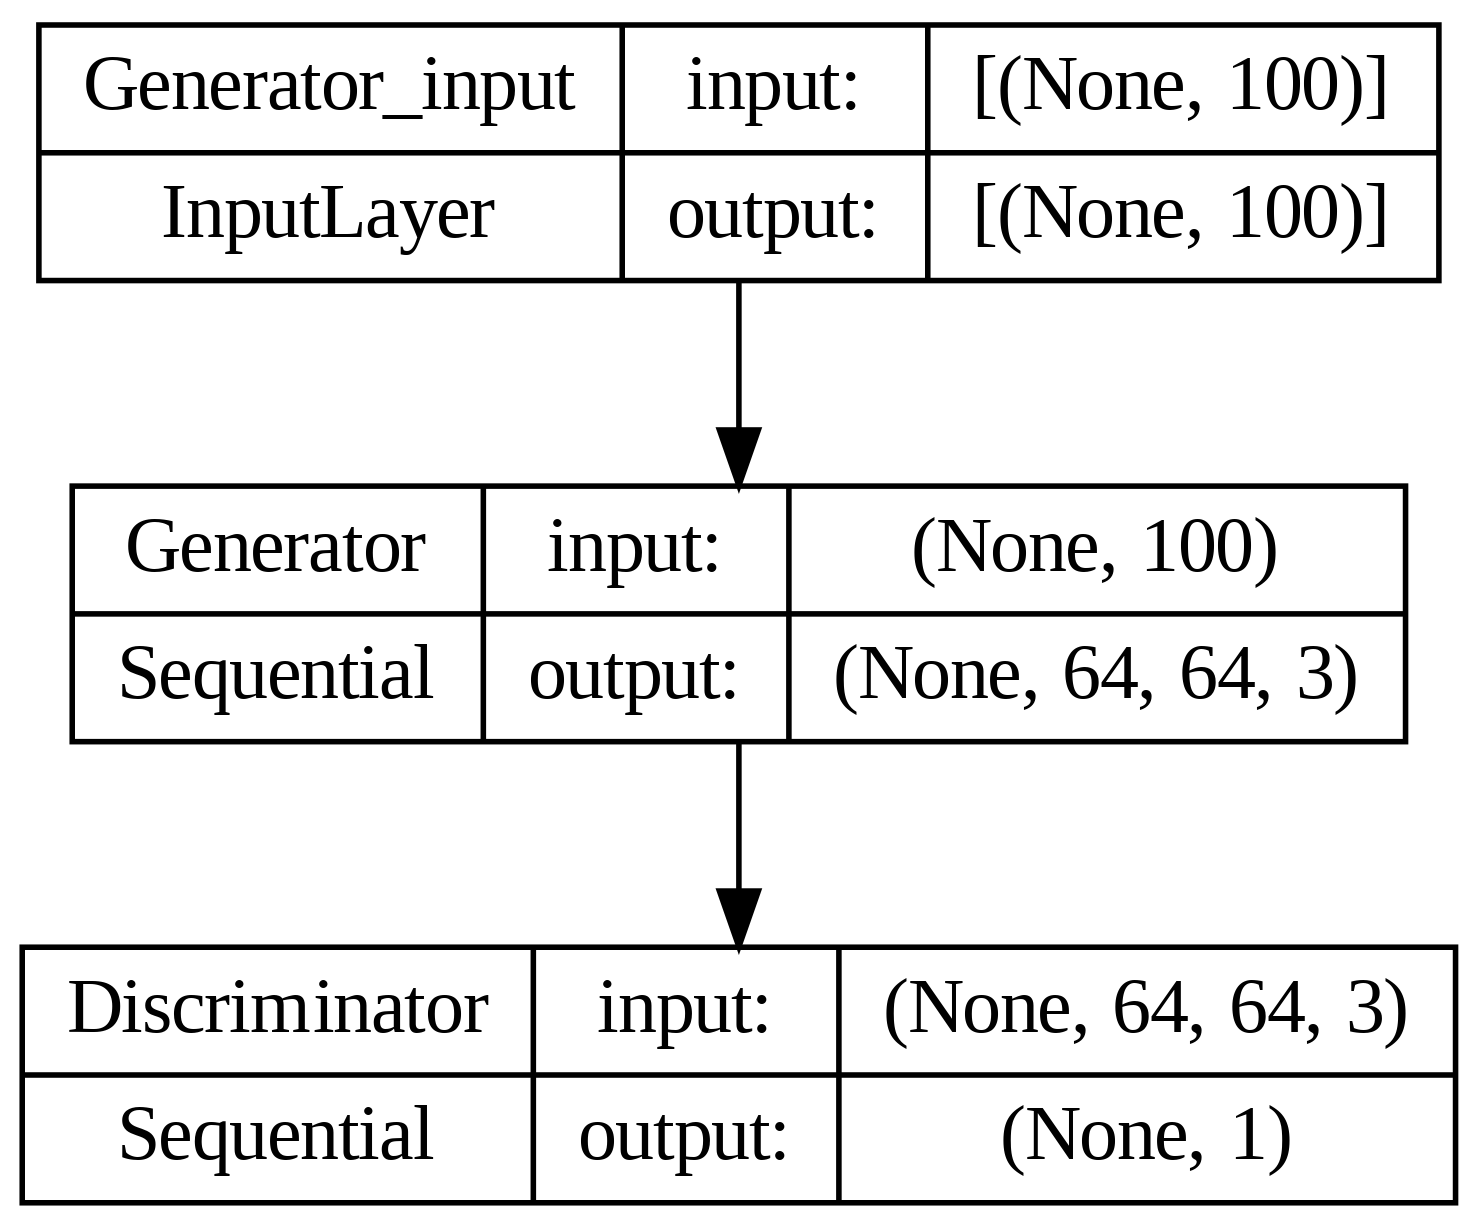

In [7]:
def def_gan(generator, discriminator):

    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False  # Setting discriminator's trainable attribute to False

    # Combine
    model = Sequential(name="DCGAN")  # Creating a Sequential model named "DCGAN"
    model.add(generator)  # Adding the generator model to the GAN model
    model.add(discriminator)  # Adding the discriminator model to the GAN model

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))  # Compiling the GAN model with binary crossentropy loss and Adam optimizer
    return model  # Returning the constructed GAN model

# Instantiate
gan_model = def_gan(gen_model, dis_model)  # Creating an instance of the GAN model using the provided generator and discriminator models

# Show model summary and plot model diagram
gan_model.summary()  # Displaying the summary of the GAN model
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=400)  # Plotting the architecture of the GAN model

### Let's create the three simple functions that helps in sampling/ generating data for the two models

*  First function draws sample real images from the data
*  Second function draws vectors from the latent space
*  Third funciton passes latent variables to generator model for generating fake examples.



In [8]:
def real_samples(n, dataset):
    # Samples of real data
    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]  # Selecting random samples from the dataset

    # Class labels
    y = np.ones((n, 1))  # Assigning class labels as 1 (real)
    return X, y  # Returning the real samples and their corresponding labels


def latent_vector(latent_dim, n):
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)  # Generating random values from a standard normal distribution

    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)  # Reshaping the generated values into a batch of inputs
    return latent_input  # Returning the latent vectors


def fake_samples(generator, latent_dim, n):
    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)  # Generating latent vectors

    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)  # Generating fake samples using the generator model

    # Create class labels
    y = np.zeros((n, 1))  # Assigning class labels as 0 (fake)
    return X, y  # Returning the fake samples and their corresponding labels

### model performance evalution

Show Discriminator model accuracy and plot real vs. fake (generated) comparison

In [9]:
def performance_summary(generator, discriminator, dataset, latent_dim, n=50):
    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)

    # Evaluate the discriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)

    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)

    # Evaluate the discriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)

    # Summarize discriminator performance
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)

    # Display 6 fake images
    x_fake_inv_trans = x_fake.reshape(-1, 1)  # Reshaping fake images for inverse transformation
    x_fake_inv_trans = scaler.inverse_transform(x_fake_inv_trans)  # Inverse transforming the scaled fake images
    x_fake_inv_trans = x_fake_inv_trans.reshape(n, 64, 64, 3)  # Reshaping the images to their original shape

    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')  # Creating subplots for displaying fake images
    k = 0
    for i in range(0, 2):
        for j in range(0, 3):
            axs[i,j].matshow(x_fake_inv_trans[k])  # Displaying the fake images
            k = k + 1
    plt.show()  # Displaying the plot

### As we can see function evaluates the Discriminator separately on real and fake (generated) points. Also, it shows a few model-generated images. Note: to display fake (generated) images, we need to inverse transform the underlying data from the [-1,1] range to the [0,1] range.

### Training function

In [10]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1001, n_batch=32, n_eval=100):
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)

    # We will manually enumerate epochs
    for i in range(n_epochs):

        # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)

        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)

        # Generator training
        # Get values from the latent space to be used as inputs for the generator
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples,
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))

        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)

        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim)

1/1 [==============================] - 6s 6s/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.6824164390563965
Generator Loss:  0.692872166633606
2/2 [==============================] - 9s 3s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.0


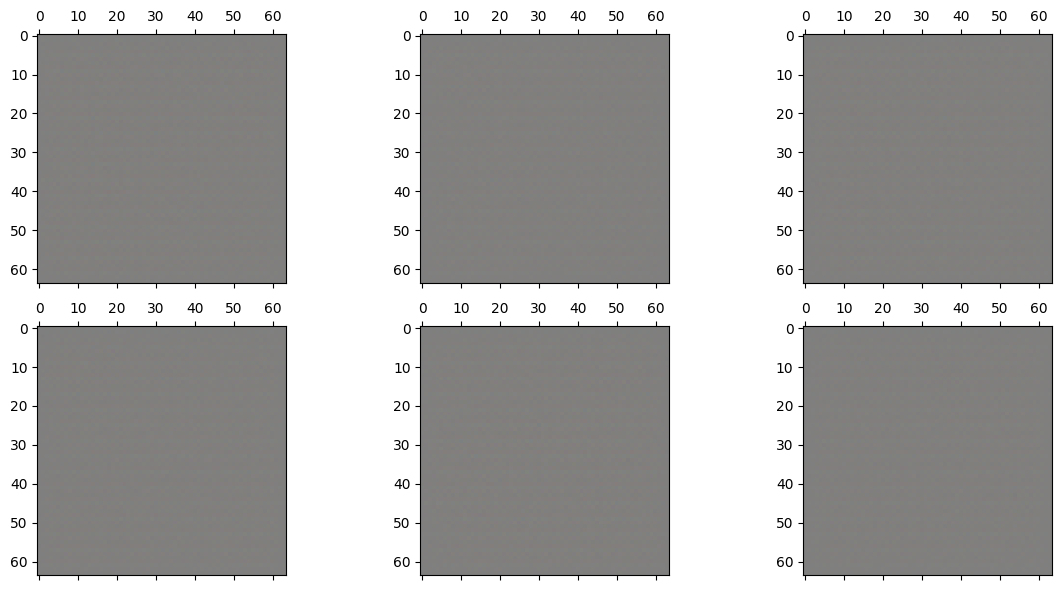

1/1 [==============================] - 3s 3s/step
Epoch number:  100
*** Training ***
Discriminator Loss  0.1567392647266388
Generator Loss:  3.3341150283813477
2/2 [==============================] - 9s 3s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.30000001192092896


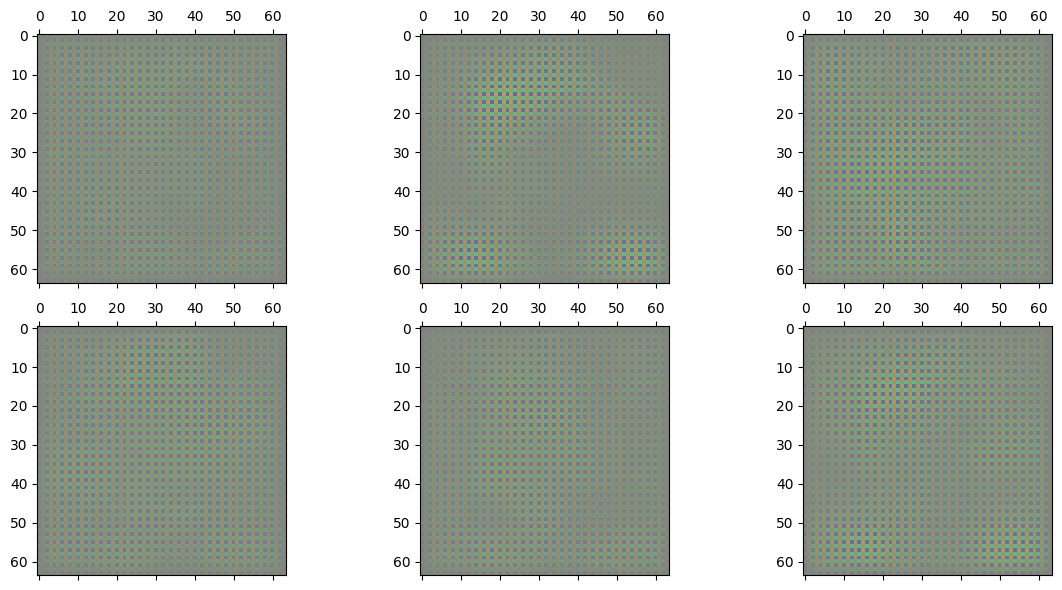

1/1 [==============================] - 3s 3s/step
Epoch number:  200
*** Training ***
Discriminator Loss  0.43350642919540405
Generator Loss:  2.0456745624542236
2/2 [==============================] - 9s 3s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7200000286102295
Discriminator Accuracy on FAKE (generated) images:  0.9399999976158142


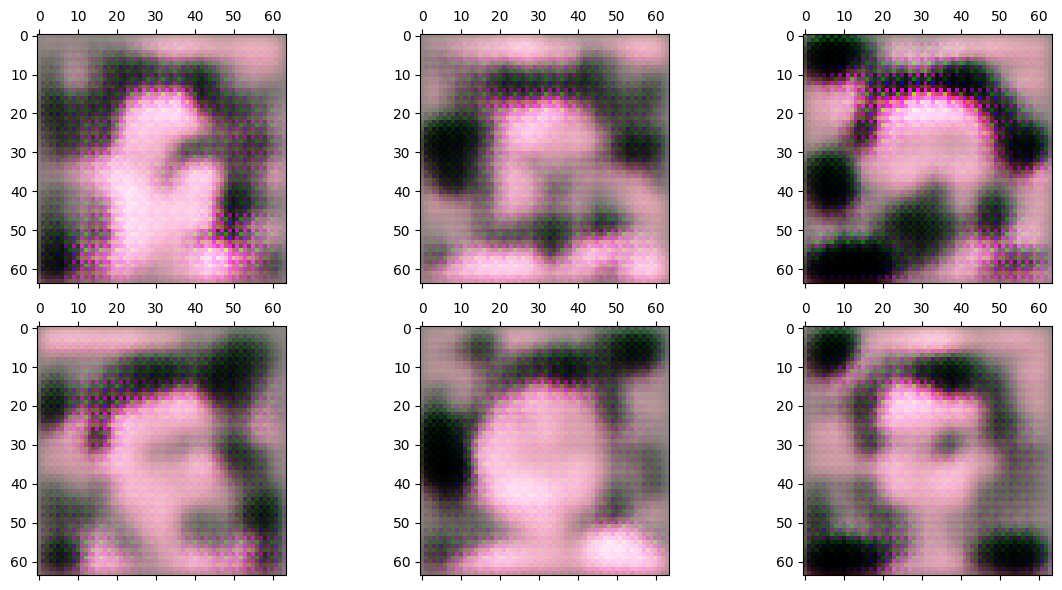

1/1 [==============================] - 3s 3s/step
Epoch number:  300
*** Training ***
Discriminator Loss  0.5922722816467285
Generator Loss:  1.056339979171753
2/2 [==============================] - 9s 3s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.699999988079071
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


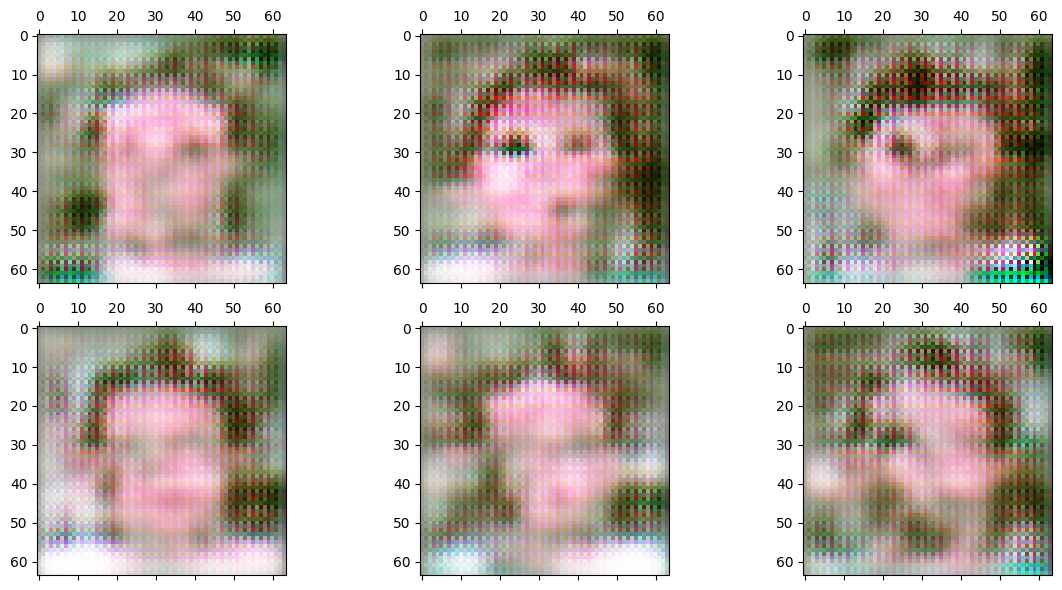

1/1 [==============================] - 3s 3s/step
Epoch number:  400
*** Training ***
Discriminator Loss  0.6697261333465576
Generator Loss:  0.909819483757019
2/2 [==============================] - 9s 3s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7200000286102295
Discriminator Accuracy on FAKE (generated) images:  0.7200000286102295


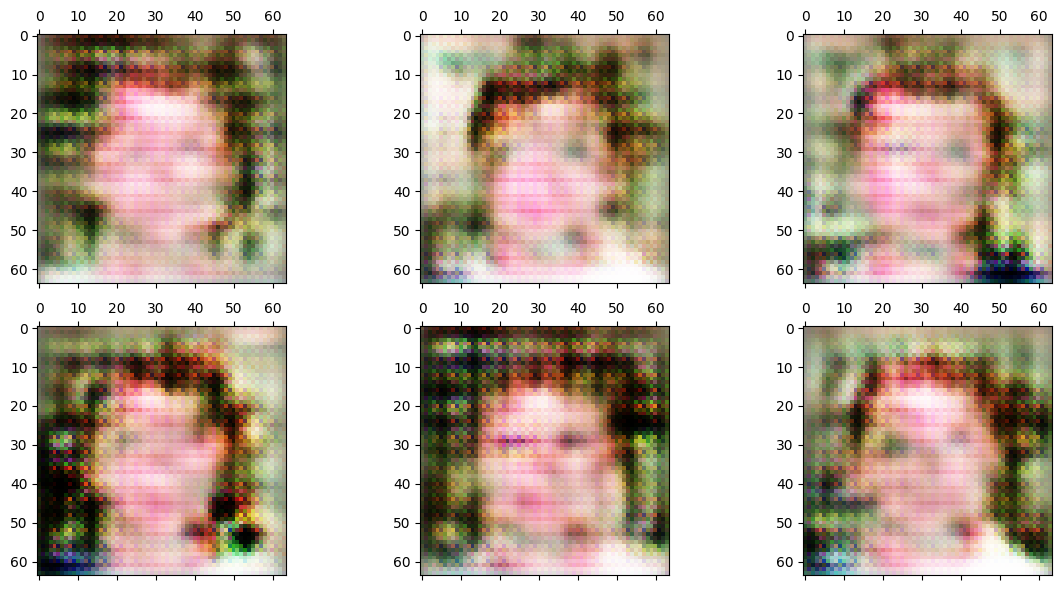

1/1 [==============================] - 3s 3s/step
Epoch number:  500
*** Training ***
Discriminator Loss  0.6021838188171387
Generator Loss:  0.8506056666374207
2/2 [==============================] - 8s 3s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9800000190734863
Discriminator Accuracy on FAKE (generated) images:  0.5


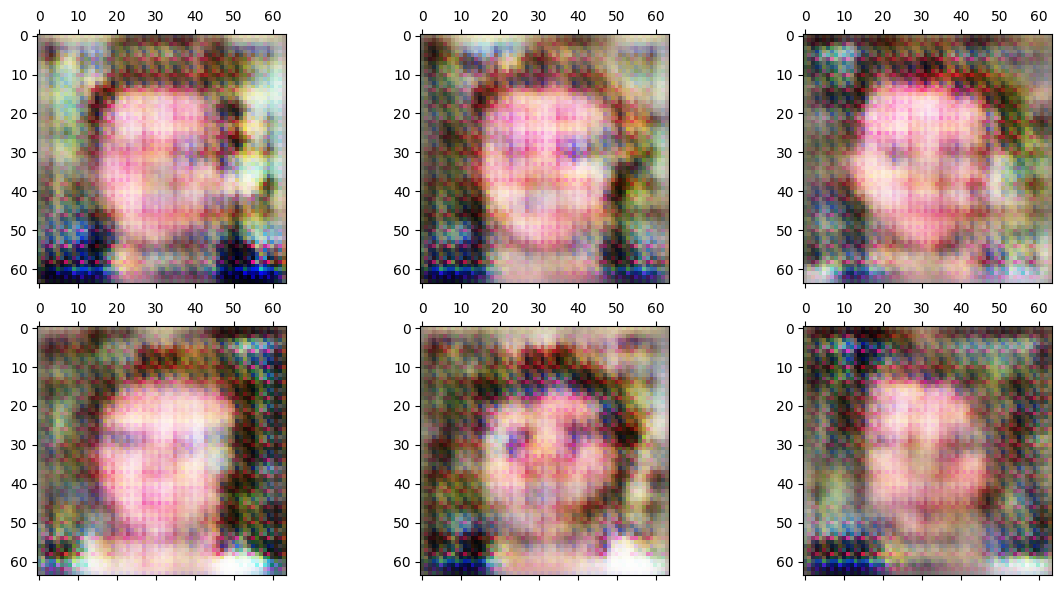

1/1 [==============================] - 3s 3s/step
Epoch number:  600
*** Training ***
Discriminator Loss  0.5866026878356934
Generator Loss:  0.9590772986412048
2/2 [==============================] - 8s 3s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.41999998688697815
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


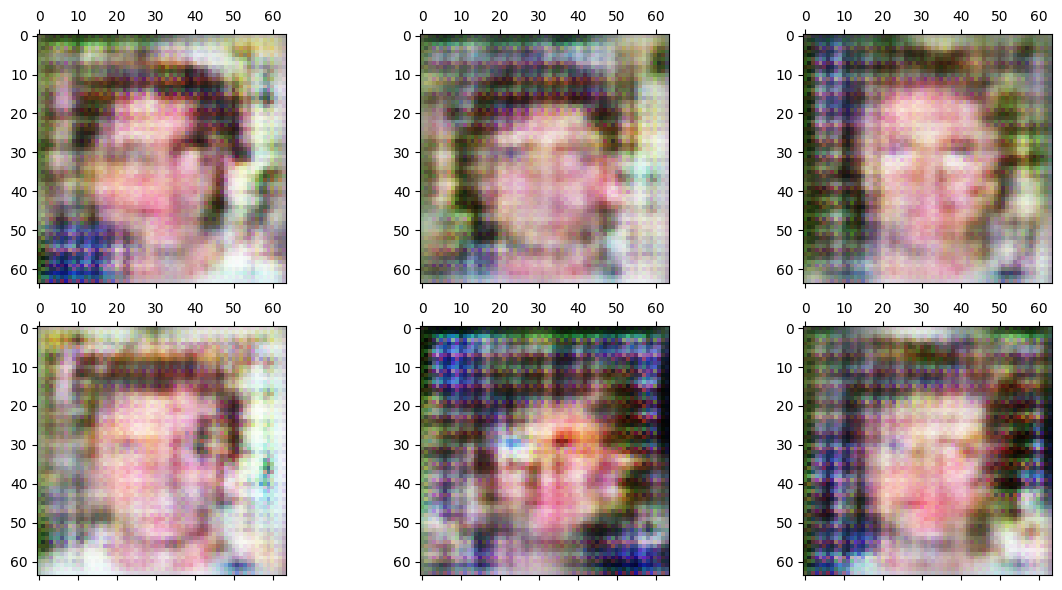

1/1 [==============================] - 3s 3s/step
Epoch number:  700
*** Training ***
Discriminator Loss  0.5556969046592712
Generator Loss:  0.8501468896865845
2/2 [==============================] - 9s 3s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7599999904632568
Discriminator Accuracy on FAKE (generated) images:  0.8600000143051147


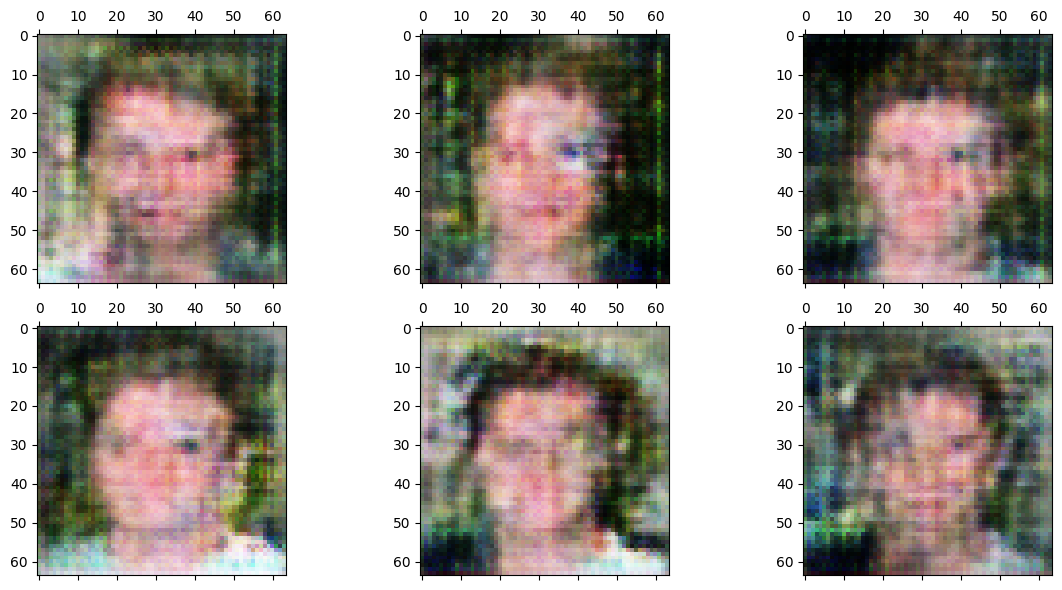

1/1 [==============================] - 3s 3s/step
Epoch number:  800
*** Training ***
Discriminator Loss  0.627998948097229
Generator Loss:  0.9083036780357361
2/2 [==============================] - 9s 3s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9599999785423279
Discriminator Accuracy on FAKE (generated) images:  0.5600000023841858


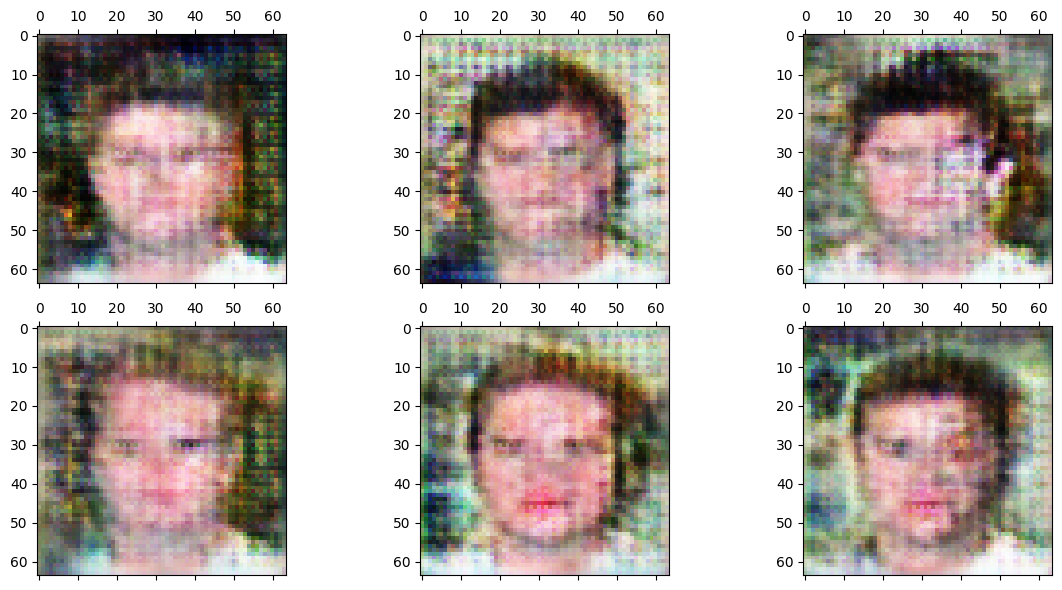

1/1 [==============================] - 3s 3s/step
Epoch number:  900
*** Training ***
Discriminator Loss  0.5725773572921753
Generator Loss:  1.0079929828643799
2/2 [==============================] - 9s 3s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5199999809265137
Discriminator Accuracy on FAKE (generated) images:  0.9399999976158142


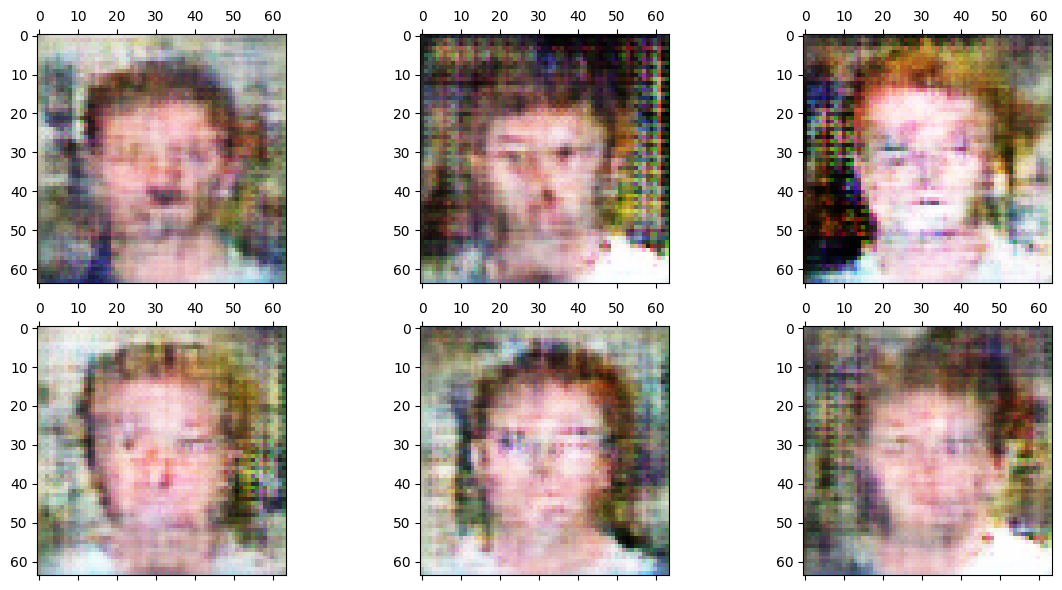

1/1 [==============================] - 3s 3s/step
Epoch number:  1000
*** Training ***
Discriminator Loss  0.6080783605575562
Generator Loss:  0.8942869901657104
2/2 [==============================] - 9s 4s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7400000095367432
Discriminator Accuracy on FAKE (generated) images:  0.5799999833106995


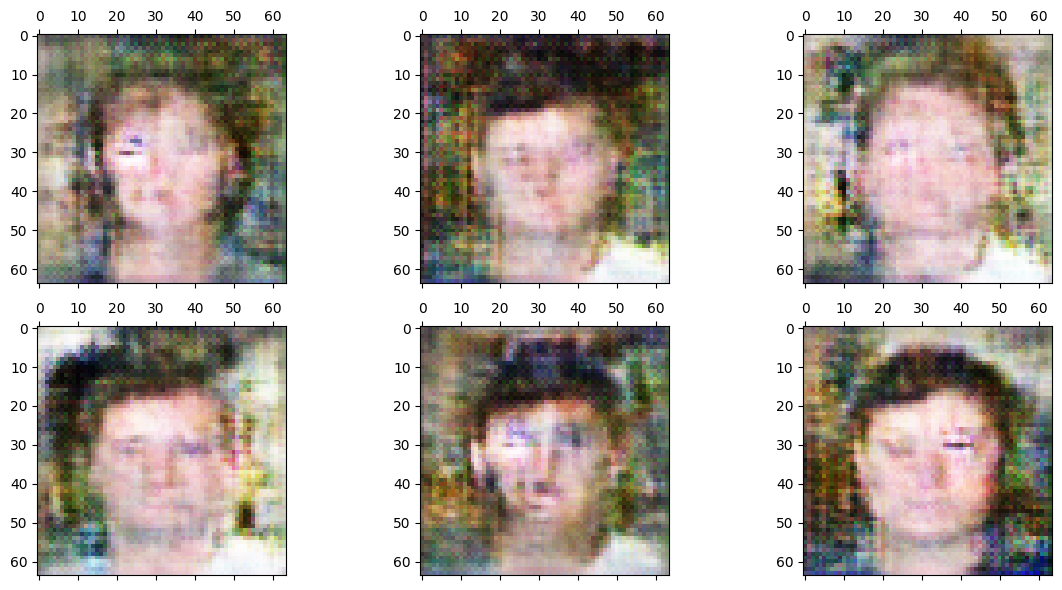

In [11]:
# Train DCGAN model
# 1k epochs
train(gen_model, dis_model, gan_model, data, latent_dim)

As we can see the picture is not upto the mark. you can perform 1000 more epochs training.

## Bonus: Generate a random image

In [12]:
# Generate an image of a face using a random latent vector
x_fake, y_fake = fake_samples(gen_model, 100, 1)

# Shape and inverse transpose the generated image
x_fake_inv_trans = x_fake.reshape(-1, 1)  # Reshaping the generated image
x_fake_inv_trans = scaler.inverse_transform(x_fake_inv_trans)  # Inverse transforming the scaled generated image
x_fake_inv_trans = x_fake_inv_trans.reshape(64, 64, 3)  # Reshaping the image to its original shape

1/1 [==============================] - 0s 171ms/step


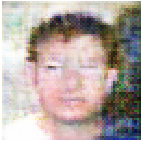

In [13]:
# Show the generated image
fig, ax = plt.subplots(figsize=(16, 9), dpi=20)  # Creating a figure and axis for plotting
ax.matshow(x_fake_inv_trans)  # Displaying the generated image
plt.axis('off')  # Turning off axis
plt.show()  # Showing the plot

<p align="center"><font size = ""><b> -- End of program -- </b><font></p>
<p align="center"><font size = "10"><b> Happy coding! ☺ </b><font></p>